# Let's go

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
from scipy.stats import norm

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

In [3]:
data_files = [
    'inliers_hi_FR_hi_GS_160C.csv',
    'inliers_hi_FR_hi_GS_200C.csv',
    'inliers_hi_FR_lo_GS_160C.csv',
    'inliers_hi_FR_lo_GS_200C.csv',
    'inliers_lo_FR_hi_GS_100C.csv',
    'inliers_lo_FR_hi_GS_160C.csv',
    'inliers_lo_FR_lo_GS_100C.csv',
    'inliers_lo_FR_lo_GS_160C.csv'
]

# Convenience functions

In [4]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [5]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [6]:
def pred_vs_actual(mod, X_test, y_test, tt):
    y_pred = mod.predict(X_test)

    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 16})

    plt.scatter(y_test, y_pred, s=15)
    plt.plot(list(range(100)), list(range(100)),
             color='k', ls='--', label='y=x')

    plt.title(tt)
    plt.xlabel(r'Test data (swelling \%)')
    plt.ylabel(r'Surrogate pred. (swelling \%)')
    plt.legend()
    plt.show()

# Load

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Can we get an xscaler without data leaks?
I guess we will do it this way for the time being.

In [8]:
ref = pd.read_csv('2025-04-19/clean_hi_FR_hi_GS_160C.csv')
ref = ref.iloc[:, :3]

xscaler = MinMaxScaler()
xscaler.fit(ref)

col_names = ref.columns

del ref

In [9]:
def load_data(fileName):
    jar = pd.read_csv(fileName)

    X = jar.iloc[:, :3].to_numpy()
    y = jar.iloc[:, -1].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=19
    )

    xscaler = MinMaxScaler()
    xscaler.fit(X_train)

    X_train = xscaler.transform(X_train)
    X_test = xscaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# NN

In [10]:
import pickle
from sklearn.neural_network import MLPRegressor

In [11]:
with open('nn_surrogates.pkl', 'rb') as f:
    regs = pickle.load(f)

# Target

In [12]:
def swelling_perc(fd):
    return 3.83e-43 * fd**2 + 4.54e-21 * fd

target = norm(swelling_perc(7e21), 1.25)

In [13]:
def proposal_dist(X, sig):
    ret = []
    
    for el in X:
        prop = np.random.normal(el, sig)
        ret.append(prop)

    assert len(X) == len(ret)
    return ret

In [14]:
def mcmc_sampler(num_param, initial_state, proposal_sig,
                 surrogates, target_fn, num_samples):
    samples = [initial_state]
    accepted = 0

    for ii in range(num_samples):
        current_state = samples[-1]
        proposed_state = proposal_dist(current_state, proposal_sig)

        valid = True
        for xx in proposed_state:
            if xx < 0 or xx > 1:
                valid = False
                break

        currs = [sur.predict([[*current_state]])[0] for sur in surrogates]
        props = [sur.predict([[*proposed_state]])[0] for sur in surrogates]
        fs_curr = mean(currs)
        fs_prop = mean(props)

        acceptance_ratio = target_fn.pdf(fs_prop) / target_fn.pdf(fs_curr)
        
        if valid and np.random.rand() < acceptance_ratio:
            current_state = proposed_state
            accepted += 1

        samples.append(current_state)

    print(f"Acceptance rate: {accepted / num_samples}")
    return np.array(samples)

In [15]:
hey1 = mcmc_sampler(
    3,
    np.random.rand(3),
    0.10,
    regs,
    target,
    100000
)

Acceptance rate: 0.21844


In [17]:
hey2 = mcmc_sampler(
    3,
    np.random.rand(3),
    0.10,
    regs,
    target,
    100000
)

Acceptance rate: 0.21969


# Trace/Hist

In [18]:
old1 = xscaler.inverse_transform(hey1)
old2 = xscaler.inverse_transform(hey2)

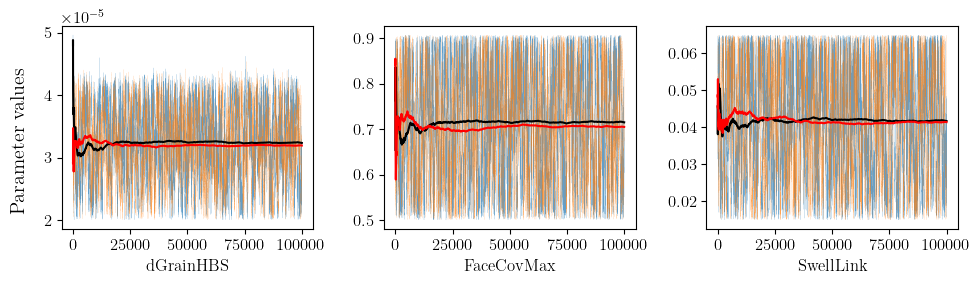

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for i, ax in enumerate(axes.flatten()):
    cdat1 = old1[:,i]
    cavg1 = np.cumsum(cdat1) / np.arange(1, len(cdat1)+1)
    ax.plot(cdat1, lw=0.1, alpha=0.7, zorder=1)
    ax.plot(cavg1, c='k', zorder=2)
    
    cdat2 = old2[:,i]
    cavg2 = np.cumsum(cdat2) / np.arange(1, len(cdat2)+1)
    ax.plot(cdat2, ls='--', lw=0.1, alpha=0.7, zorder=1)
    ax.plot(cavg2, c='r', zorder=2)
    
    ax.set_xlabel(col_names[i])
    #ax.set_ylim([0, 1])

#fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

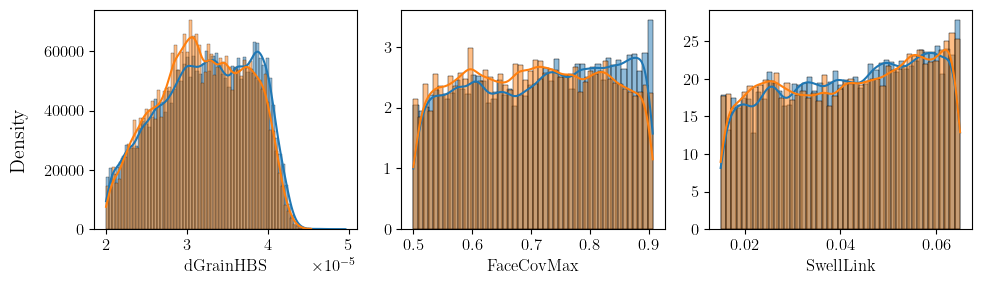

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

for i, ax in enumerate(axes.flatten()):
    sns.histplot(old1[:,i], ax=ax, stat='density', kde=True)
    sns.histplot(old2[:,i], ax=ax, stat='density', kde=True)
    ax.set_xlabel(col_names[i])
    ax.set_ylabel('')
    #ax.set_xlim([0, 1])

#fig.delaxes(axes[1,3])
fig.supylabel('Density')
plt.tight_layout()
plt.show()

# Data thinning

In [21]:
chey = np.concatenate((hey1[::100], hey2[::100]))

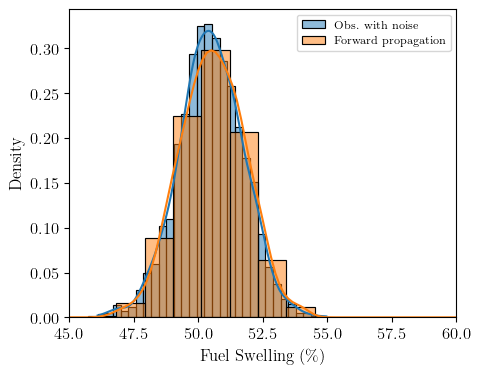

In [22]:
orig = []
res = []
for i in range(2000):
    ress = [reg.predict([chey[-i]])[0] for reg in regs]
    res.append(mean(ress))
    #res.append(reg_las3.predict([yeh[-i]])[0])
    c = np.random.normal(swelling_perc(7e21), 1.25)
    orig.append(c)
    
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')

plt.xlim([45, 60])
plt.xlabel(r'Fuel Swelling (\%)')
plt.legend(fontsize='x-small', loc='upper right')
plt.show()

In [23]:
cold = np.concatenate((old1[::100], old2[::100]))

<Figure size 1000x800 with 0 Axes>

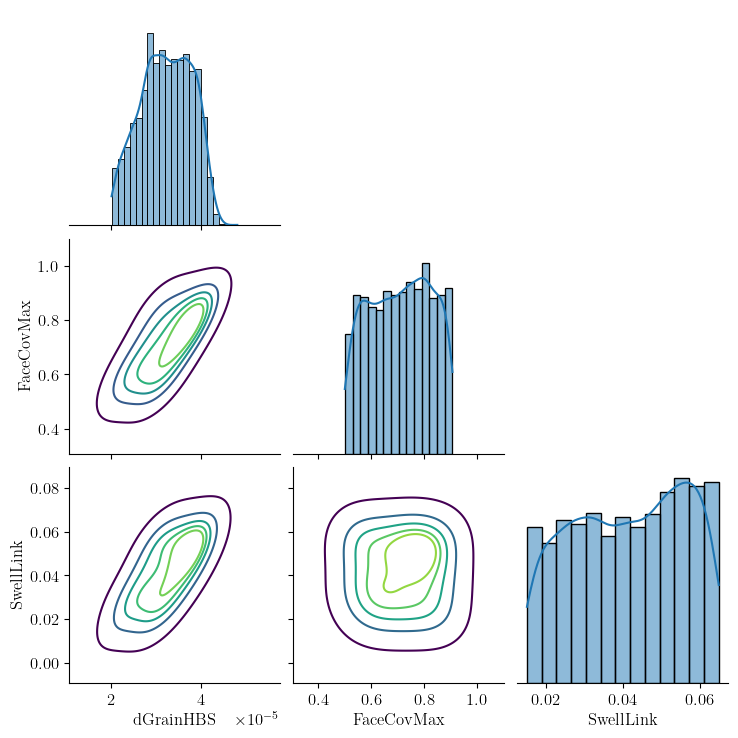

In [24]:
oldd = pd.DataFrame(cold, columns=['dGrainHBS', 'FaceCovMax', 'SwellLink'])

plt.figure(figsize=(10, 8))
sns.pairplot(
    pd.DataFrame(oldd),
    diag_kind='hist',
    diag_kws=dict(kde=True),
    plot_kws=dict(levels=6, bw_adjust=2.0, cmap='viridis'),
    kind='kde',
    corner=True
)

plt.show()

# Save

In [25]:
oldd.to_csv('mcmc_samples.csv', index=False)